Author: **Ivan Bongiorni**. 2020-05-21.

Repository: https://github.com/IvanBongiorni/GAN-RNN_Timeseries-imputation

# Study of missing values distribution

This Notebook represents a "handmade" study I made before the actual model implementation. It is about how missing values are distributed in the dataset, and how their occurrence can be replicated. The artifical deterioration of trends is based on the evidence gathered.

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn

import deterioration
import tools

In [2]:
# Load data and config params
df = pd.read_csv( os.getcwd() + '/data_raw/train_2.csv')
df.drop('Page', axis = 1, inplace = True)
df = df.values

params = yaml.load( open(os.getcwd() + '/config.yaml'), yaml.Loader ) 

In [3]:
# Quick preprocessing
def left_zero_fill(x):
    if np.isfinite(x[0]): 
        return x

    cumsum = np.cumsum(np.isnan(x))    
    x[ :np.argmax(cumsum[:-1]==cumsum[1:]) +1] = 0
    return x

for i in range(df.shape[0]):
    df[ i , : ] = left_zero_fill( df[ i , : ] )

# take rows with NaN's only
X = df[ np.isnan(df).any(axis=1)]

# Full trends
F = df[ ~np.isnan(df).any(axis=1)] 

In [4]:
print(X.shape) 

(18969, 803)


# Overall NaN distribution

I will now analyse the distribution of NaN's of the trends, taken as a whole, in order to understand how they are distributed in the dataset.

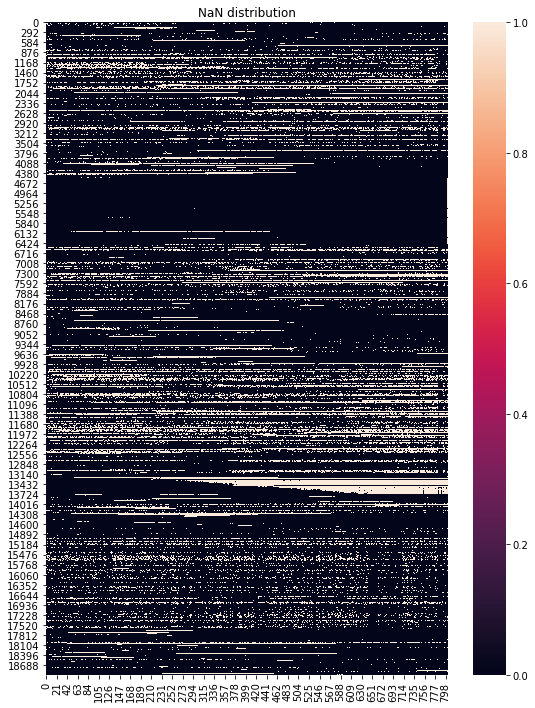

In [5]:
plt.figure(figsize=(9,12))
seaborn.heatmap(np.isnan(X))
plt.title('NaN distribution')
plt.show() 

It appears missing values appear in my dataset in two main ways:
- Pure random noise.
- A whole interval is "blank".

My deterioration function will have to replicate both.

# NaN distribution on RNN-preprocessed series

RNNs will be fed with input series that are subsets of the whole trends, with their length being determined by parameter '`len_input`' from `config.yaml`.

In [6]:
# Extract few trends from dataset and preprocess for RNNs
R = X[ np.random.choice(X.shape[0], size=200, replace=False) , : ]

def _univariate_processing(series, len_input):
    S = [ series[i : i+len_input] for i in range(len(series)-len_input+1) ]
    return np.stack(S)

R = [ _univariate_processing(R[i,:], 128) for i in range(R.shape[0]) ]
R = np.concatenate(R) 

print(R.shape) 

(135200, 128)


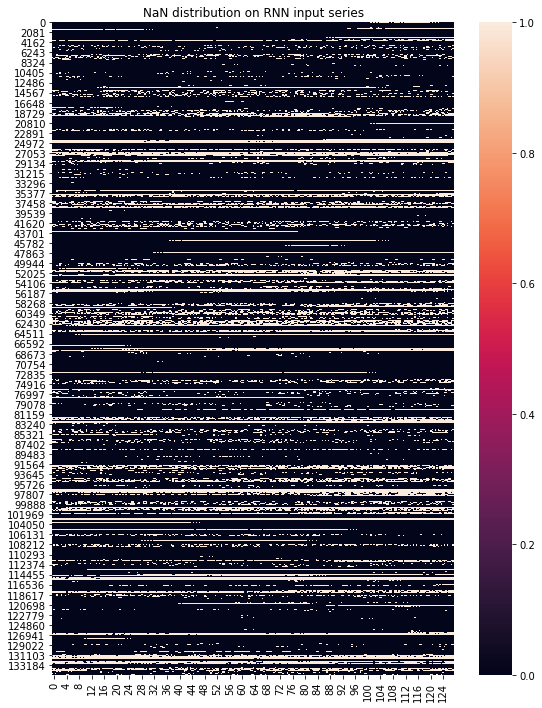

In [7]:
plt.figure(figsize=(9,12))
seaborn.heatmap(np.isnan(R))
plt.title('NaN distribution on RNN input series')
plt.show() 

In [8]:
# Plot distribution of NaN ratio by row
nan_count = np.isnan(R).sum(axis=1) 
nan_ratio = nan_count / R.shape[1] 

print(np.min(nan_count))
print(np.mean(nan_count))
print(np.max(nan_count))
print()
print(np.min(nan_ratio))
print(np.mean(nan_ratio))
print(np.max(nan_ratio)) 

0
21.801523668639053
128

0.0
0.1703244036612426
1.0


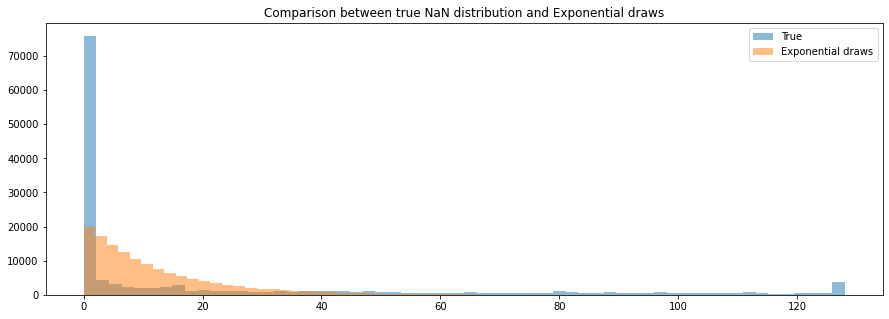

In [9]:
# Generate distribution sampled from Exponential distribution
exp_draw = np.random.exponential(scale = np.std(nan_count)/3, size = len(nan_count)) 

# All draws higher than empirical max are broguht back to zero (rule of thumb)
exp_draw[ exp_draw > np.max(nan_count) ] = 0

plt.figure(figsize=(15,5)) 
plt.hist(nan_count, bins = 60, label = 'True', alpha = 0.5)
plt.hist(exp_draw, bins = 60, label = 'Exponential draws', alpha = 0.5)
plt.title('Comparison between true NaN distribution and Exponential draws')
plt.legend()
plt.show() 

As I found by playing with probability distributions, the true NaN frequency looks very Exponential. However, I don't want my model to replicate *exactly that*. I want to avoid having training series with too little or too much missing values.

# Deterioration functions

I must write a function that generates the two kinds of artificial deteriorations explained above: pure random perturbations and NaN intervals. To do that, I will imitate tossing a coin, choosing between one of the two kinds of perturbations.

This probability is a model hyperparameter. By tweaking it in prototyping phase I noticed that NaN intervals are a more challenging problem for a Neural Network. A whole missing interval forces them to learn long term patterns, instead of simply filling a small piece in more complete and informative observations.

In [10]:
print(params['prob_noise']) # Pr of applying random noise vs NaN interval

0.25


The deterioration function is stored in `deterioration.py` script, in order to be updated and/or corrected more easily.

In [11]:
params['size_nan'] = int(params['len_input']*params['total_nan_share'])
D = deterioration.mask(R, params) 

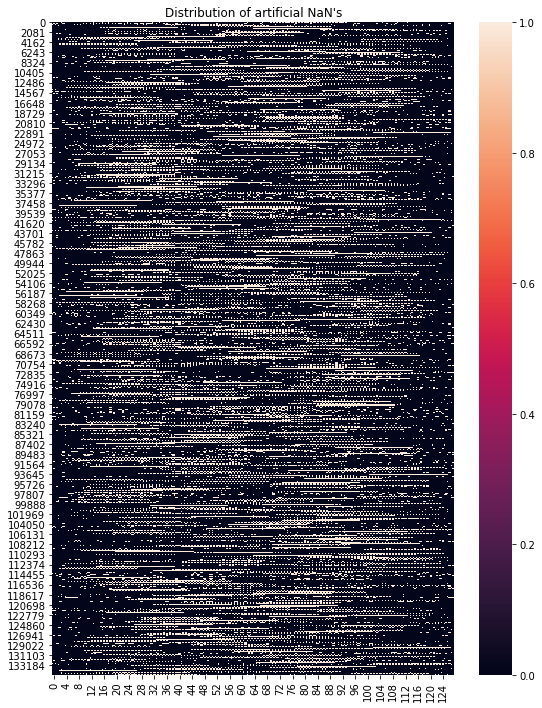

In [12]:
plt.figure(figsize=(9,12))
seaborn.heatmap(D)
plt.title("Distribution of artificial NaN's")
plt.show() 

In [13]:
# artificial_nan_count = (D==0) * 1
artificial_nan_count = D.sum(axis=1) 

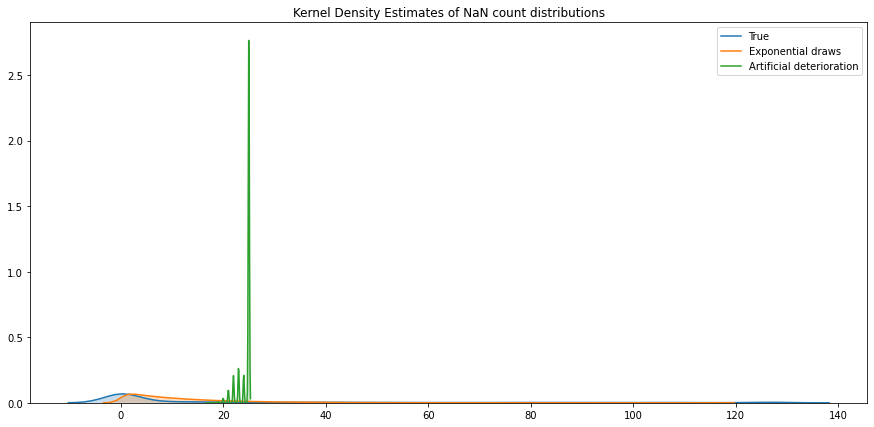

In [14]:
# artificial_nan_count = np.isnan(D).sum(axis=1) 

plt.figure(figsize=(15,7)) 
seaborn.kdeplot(nan_count, shade = True, label = 'True')
seaborn.kdeplot(exp_draw, shade = True, label = 'Exponential draws')
seaborn.kdeplot(artificial_nan_count[:len(nan_count)], shade = True, label = 'Artificial deterioration')
plt.title('Kernel Density Estimates of NaN count distributions')
plt.legend()
plt.show() 

The distribution of artificial NaN's (green) is what I was looking for. 

I created an artificial NaN distribution (green curve) that is significantly higher than the real one. The reason for this is that my Neural Network need as many examples as possible to learn from, and trends with too little missing data wouldn't properly train it. On the other side, I didn't want my train set to be almost completely NaN, since the model wouldn't be able to learn much from it either.

The NaN ratio I set in `params['total_nan_share']` is satisfying as it found a good trade off.

Now I have an artificial deterioration function that I can use to simulate the occurrence of missing values. With that, any input sequence that will be fed into my Neural Networks will contain a NaN simulation, to be associated with groundtruth data to train the model with.

# Examples

In [15]:
# take a subsample of full trends
F_sub = F[ np.random.choice(F.shape[0], size=200, replace=False) , : ]
F_sub = [ _univariate_processing(F_sub[i,:], 128) for i in range(F_sub.shape[0]) ]
F_sub = np.concatenate(F_sub) 

In [16]:
mask = deterioration.mask(F_sub, params) 
det_F_sub = np.where(mask==1, np.nan, F_sub) 

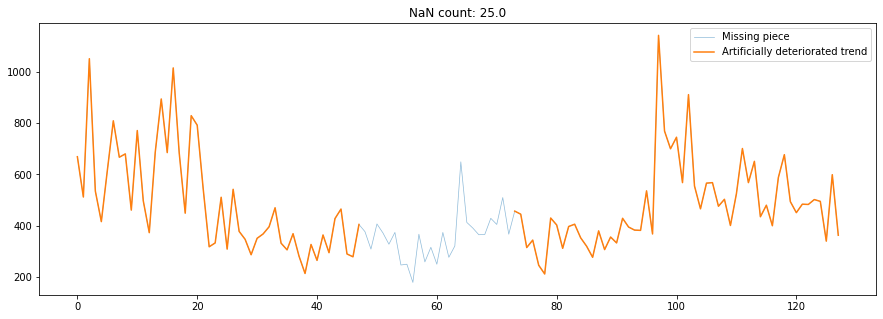

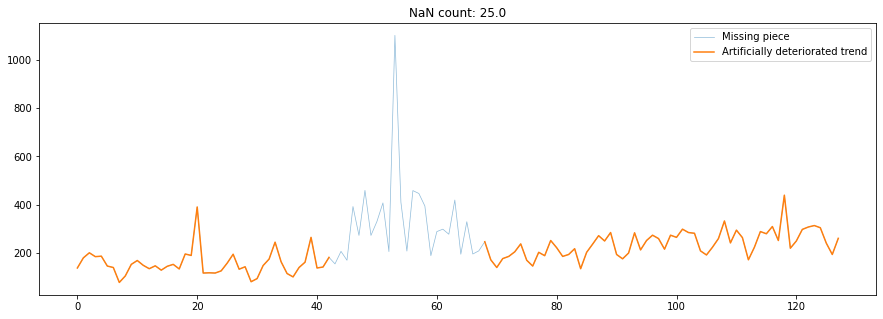

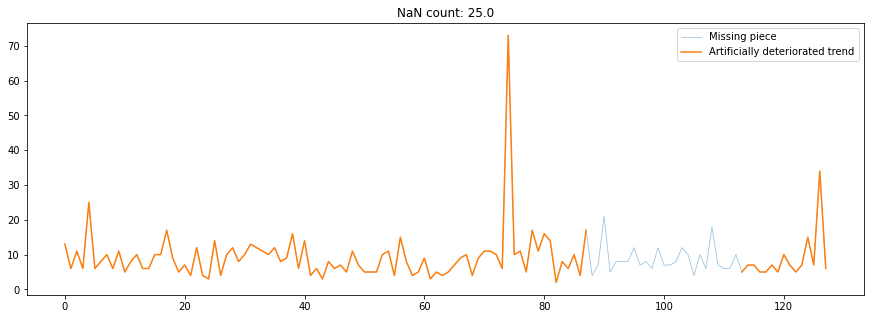

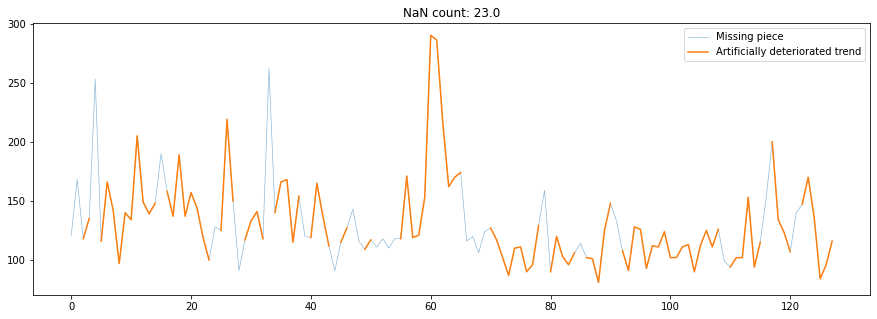

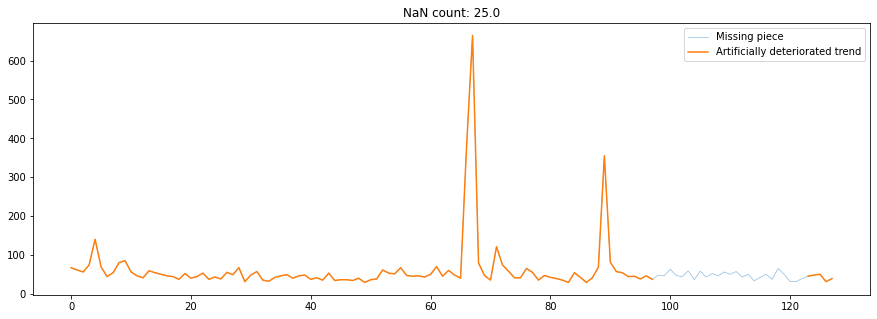

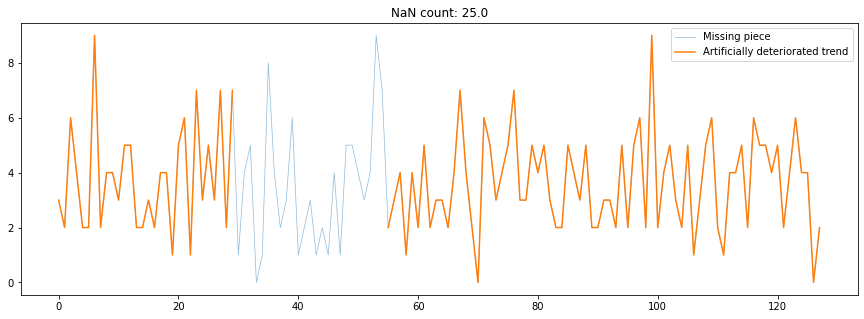

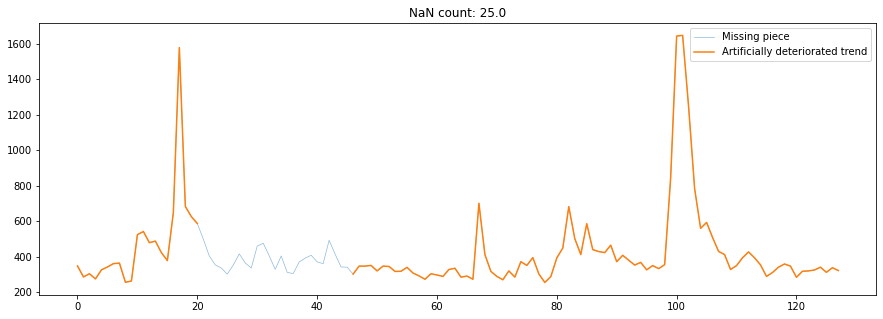

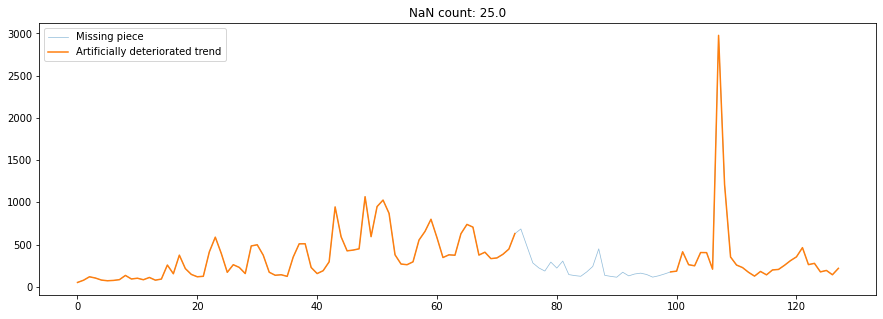

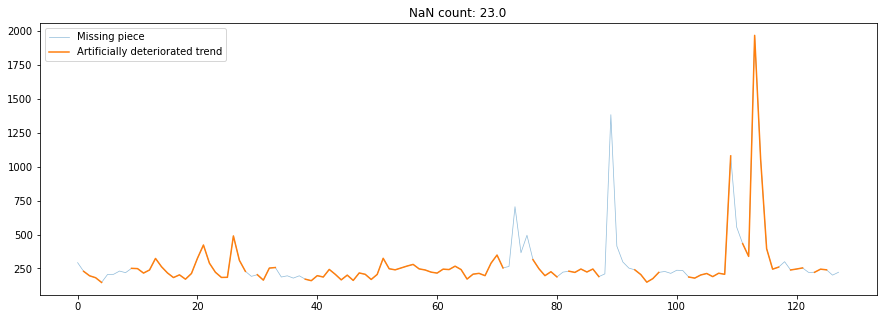

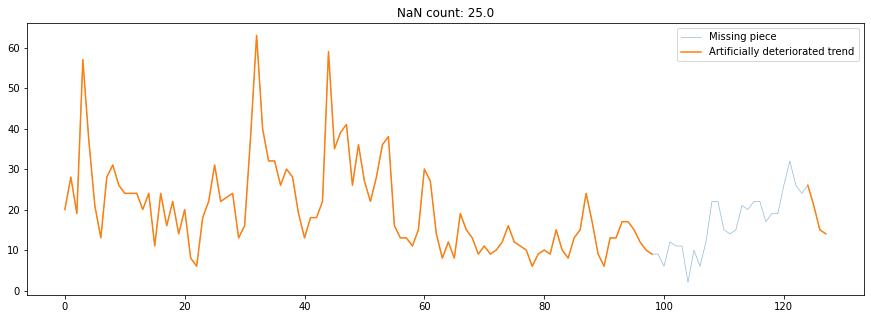

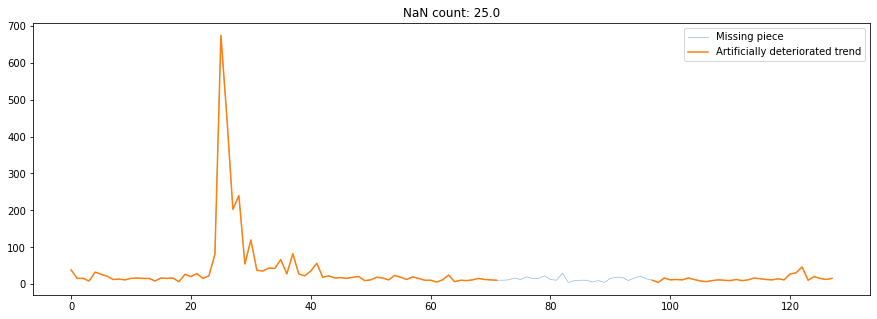

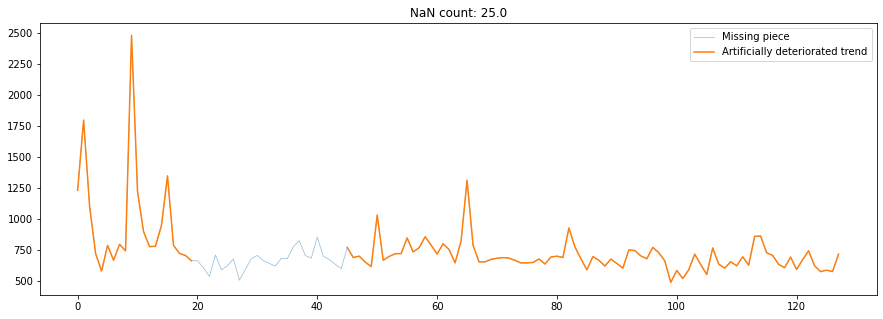

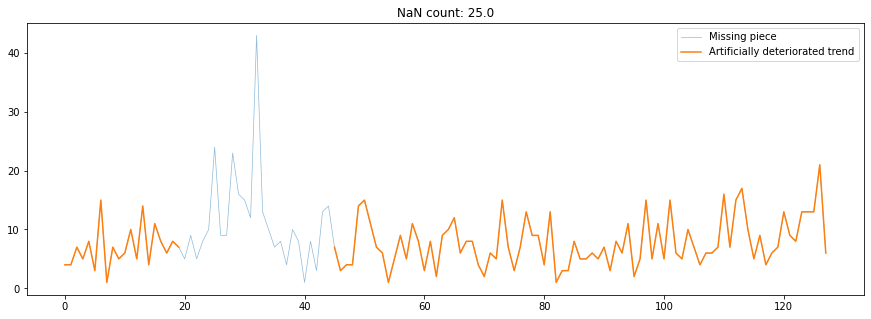

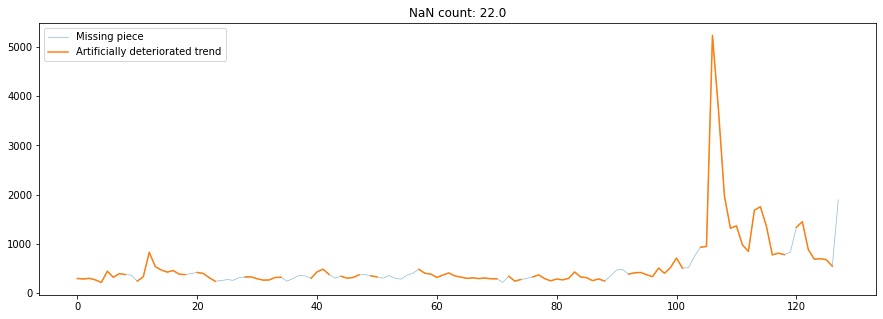

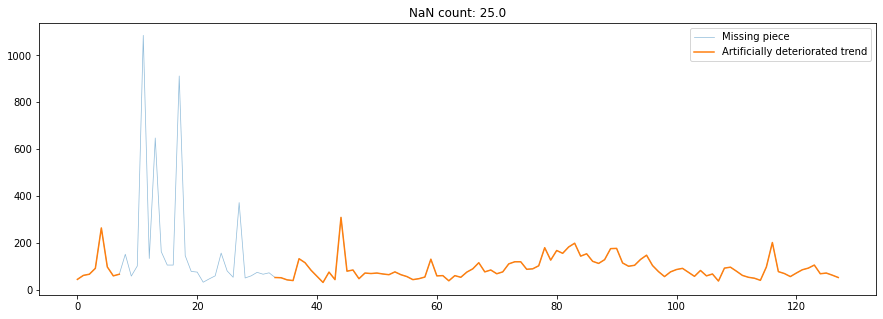

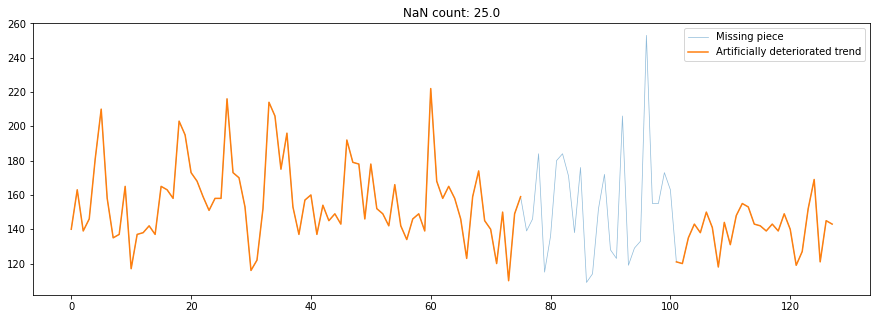

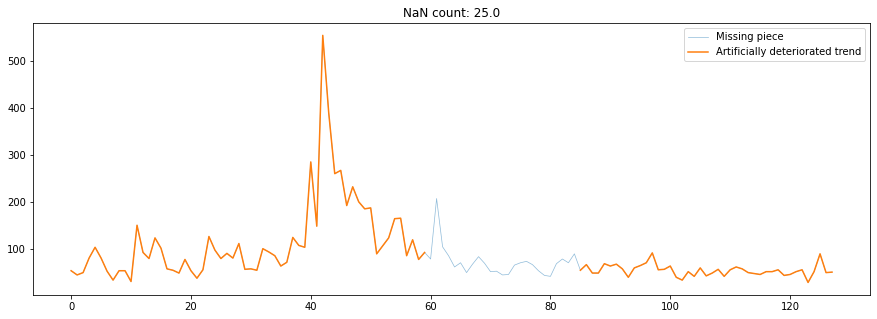

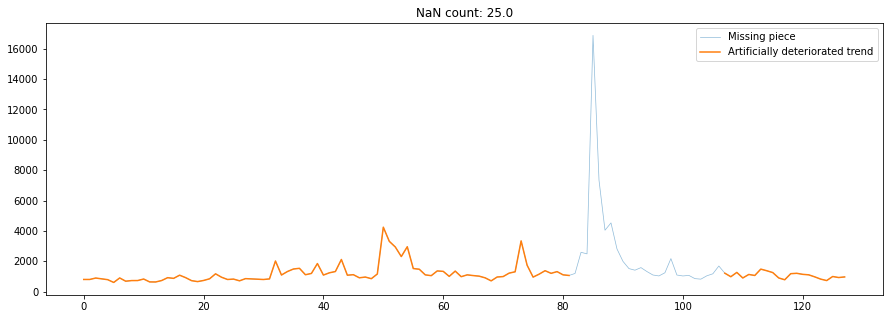

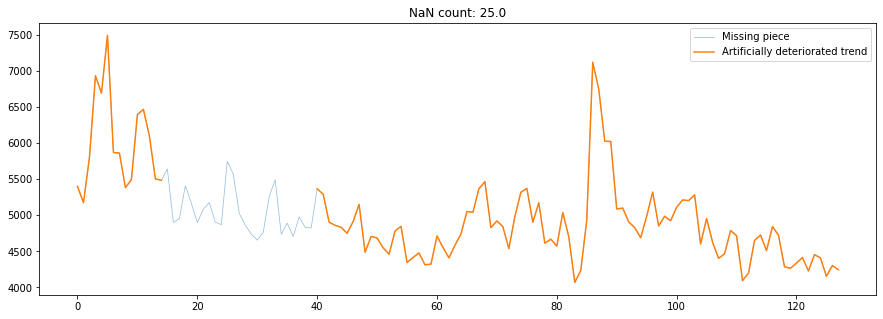

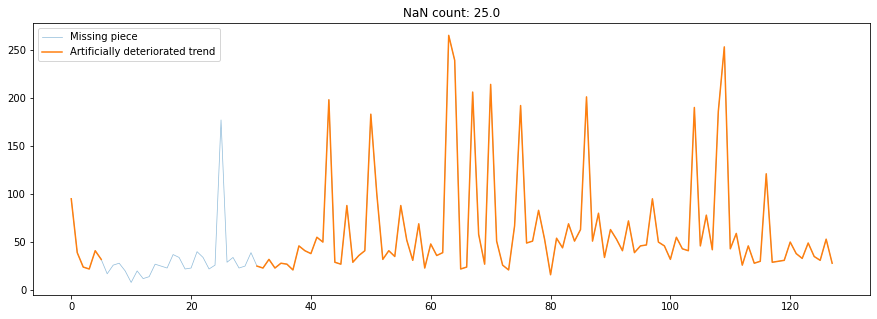

In [17]:
for i in np.random.choice(F_sub.shape[0], size=20, replace=False):
    plt.figure(figsize=(15,5)) 
    plt.plot(F_sub[i,:], label='Missing piece', alpha=0.5, linewidth=0.7)
    plt.plot(det_F_sub[i,:], label='Artificially deteriorated trend', linewidth=1.5)
    plt.title('NaN count: {}'.format(np.sum(mask[i,:]))) 
    plt.legend()
    plt.show() 